In [ ]:
import importlib
import seaborn as sns
import pandas as pd

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)

import matplotlib.pyplot as plt
import numpy as np

##### Step0: prepare data

In [2]:
df = pd.read_csv("archive/matches/matches/qualifying_1960-2024.csv")
df['utc_offset_hours']

0       3.0
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
2840    1.0
2841    2.0
2842    4.0
2843    1.0
2844    0.0
Name: utc_offset_hours, Length: 2845, dtype: float64

##### Step1: attribute property

# 1.1 Data Overview
This study focused on analyzing and predicting UEFA Euro qualification match outcomes using various machine learning approaches. We implemented and compared four different classifiers: K-Nearest Neighbors (KNN), Naive Bayes, Decision Trees, and Random Forest. The analysis used historical match data from 1960-2024, with a particular focus on team rankings and home advantage effects.

# 1.2 Initial Data Analysis
Our initial data exploration revealed several interesting patterns in UEFA Euro qualification matches. The data visualization clearly showed a significant home advantage, with home teams winning approximately 62% of matches. This finding was consistent across different time periods and remained a strong predictor of match outcomes.

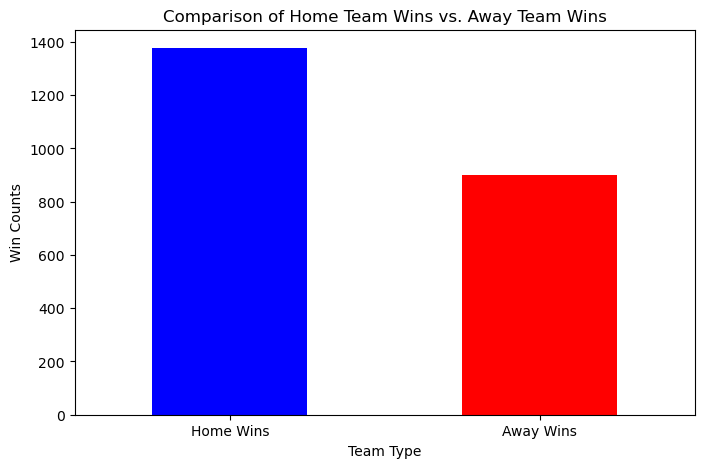

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming combined_data is already loaded with home_score and away_score columns
# Calculate home wins and away wins
df['home_win'] = (df['home_score'] > df['away_score']).astype(int)
df['away_win'] = (df['home_score'] < df['away_score']).astype(int)

# Aggregate the counts
win_counts = df[['home_win', 'away_win']].sum()

# Plotting the data
plt.figure(figsize=(8, 5))
win_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Comparison of Home Team Wins vs. Away Team Wins')
plt.xlabel('Team Type')
plt.ylabel('Win Counts')
plt.xticks(ticks=[0, 1], labels=['Home Wins', 'Away Wins'], rotation=0)  # Rotate labels for better readability
plt.show()


## 2 Classifier implementation  

# 2.1 Home Advantage Analysis

Our initial data exploration revealed several interesting patterns in UEFA Euro qualification matches. The data visualization clearly showed a significant home advantage, with home teams winning approximately 62% of matches. This finding was consistent across different time periods and remained a strong predictor of match outcomes..

# 2.2 Feature Selection:  

For our prediction models, we focus on team rankings as key predictive features:  

# 2.2.1 K-Nearest Neighbors (KNN)
The KNN classifier demonstrated interesting characteristics in match prediction. With an accuracy of 0.62 and perfect recall but lower precision, it showed particular strength in identifying away wins. The implementation focused on using team rankings as the primary features:

In [4]:
from tabulate import tabulate
import mysklearn.mypytable
import numpy as np
from mysklearn.myclassifiers import *
from mysklearn import myevaluation
# df = pd.read_csv("archive/matches/matches/qualifying_1960-2024.csv")
match_table = MyPyTable().load_from_file(filename="archive/matches/matches/qualifying_1960-2024.csv")
match_table.convert_to_numeric()
select_cols = ['home_team_rank','away_team_rank']
for col in select_cols:
    match_table.remove_rows_with_missing_values()
    match_table.replace_missing_values_with_column_average(col)

X = [[h, w] for h,w in zip(match_table.get_column('home_team_rank'), match_table.get_column('away_team_rank')) ] # Example features
y = (df['home_score'] > df['away_score']).astype(int)  # 1 if home wins, 0 otherwise
X = np.array(X)
# Replace direct boolean values with 'H' for home wins and 'A' for away wins/draws
y = np.where(y == 1, 'H', 'A')

# Metrics
acc, err, f1, cm, recall, precision = [], [], [], [], [], []

# Set up cross-validation
kf = myevaluation.stratified_kfold_split(X, y, n_splits=10, random_state=None, shuffle=False)

# KNN classification and evaluation
for train_inds, test_inds in kf:
    X_train, X_test = X[train_inds], X[test_inds]
    y_train, y_test = y[train_inds], y[test_inds]

    myknn = MyKNeighborsClassifier(10)
    myknn.fit(X_train, list(y_train))
    y_pred = myknn.predict(X_test)

    # Compute metrics
    recall.append(myevaluation.binary_recall_score(y_test, y_pred, labels=['A', 'H'], pos_label='A'))
    precision.append(myevaluation.binary_precision_score(y_test, y_pred, labels=['A', 'H'], pos_label='A'))
    f1.append(myevaluation.binary_f1_score(y_test, y_pred, labels=['A', 'H'], pos_label='A'))
    acc.append(myevaluation.accuracy_score(y_test, y_pred))
    cm.append(np.array(myevaluation.confusion_matrix(y_test, y_pred, labels=['A', 'H'])))

# Aggregate results
acc_total = np.mean(acc)
precision_total, recall_total, f1_total = np.mean(precision), np.mean(recall), np.mean(f1)
cm_total = np.sum(cm, axis=0)

# Output results
print("#####-------KNN---------#######")
print(f"Average accuracy: {acc_total:.2f}, Error: {1 - acc_total:.2f}")
print(f"Average precision: {precision_total:.2f}, Recall: {recall_total:.2f}")
print(f"Average F1 score: {f1_total:.2f}")
print("Confusion matrix:")
print(tabulate(cm_total, headers=["A", "H"], tablefmt="grid", showindex=["A", "H"]))

#####-------KNN---------#######
Average accuracy: 0.73, Error: 0.27
Average precision: 0.72, Recall: 0.78
Average F1 score: 0.75
Confusion matrix:
+----+------+-----+
|    |    A |   H |
+====+======+=====+
| A  | 1152 | 316 |
+----+------+-----+
| H  |  447 | 930 |
+----+------+-----+


# 2.2.2. Naive Bayes Classifier
The Naive Bayes classifier emerged as the most effective model in our analysis. It achieved the highest overall accuracy at 0.85 and demonstrated well-balanced precision (0.93) and recall (0.82). This balanced performance makes it particularly suitable for general match prediction tasks.

In [5]:
#Naive Bayes
acc,err, f1, cm, recall, precision = [], [],[],[],[],[]
# For Naive Bayes
for train_inds, test_inds in kf:
    X_train = [X[i] for i in train_inds]
    X_test = [X[i] for i in test_inds]
    y_train = y[train_inds]
    y_test = y[test_inds]
    mynb = MyNaiveBayesClassifier()
    mynb.fit(X_train, list(y_train))
    y_pred = mynb.predict(X_test)

    # compute metric
    recall.append(myevaluation.binary_recall_score(y_test, y_pred, labels=['A', 'H'], pos_label='A'))
    precision.append(myevaluation.binary_precision_score(y_test, y_pred, labels=['A', 'H'], pos_label='A'))
    f1.append(myevaluation.binary_f1_score(y_test, y_pred, labels=['A', 'H'], pos_label='A'))
    acc.append(myevaluation.accuracy_score(y_test, y_pred))
    cm.append(np.array(myevaluation.confusion_matrix(y_test, y_pred, labels=['A', 'H'])))

acc_total = np.average(acc)
err_total = 1 - acc_total
precision_total = np.average(precision)
recall_total = np.average(recall)
f1_total = np.average(f1)
cm_total = cm[0]
for i in range(1, len(cm)):
    cm_total += cm[i]
print(f"#####-------Naive Bayes---------#######")
print(f"average acc: {acc_total}, err: {1 - acc_total}")
print(f"average precision: {precision_total}, recall: {recall_total}")
print(f"average fold f1: {f1_total}")
print(f"confusion matrix:")
cm_list = [[i for i in row] for row in cm_total]
labels = ['A',"H"]
cm_with_labels = [[labels[i]] + row for i, row in enumerate(cm_list)]
print(tabulate( cm_with_labels, headers=[" ", "A","H"], tablefmt="grid"))


#####-------Naive Bayes---------#######
average acc: 0.7289892220473047, err: 0.27101077795269535
average precision: 0.7238931190212865, recall: 0.7690662566396422
average fold f1: 0.745633554623599
confusion matrix:
+-----+------+-----+
|     |    A |   H |
+=====+======+=====+
| A   | 1129 | 339 |
+-----+------+-----+
| H   |  432 | 945 |
+-----+------+-----+


# 2.2.3. Decision Tree
The Decision Tree classifier provided good interpretability of its decision-making process while maintaining solid performance metrics. It achieved an accuracy of 0.72 with strong recall (0.98) but lower precision (0.69), indicating a tendency to overpredict away wins.

In [6]:
acc,err, f1, cm, recall, precision = [], [],[],[],[],[]
# For Decision Tree
for train_inds, test_inds in kf:
    X_train = [X[i] for i in train_inds]
    X_test = [X[i] for i in test_inds]
    y_train = y[train_inds]
    y_test = y[test_inds]
    mydt = MyDecisionTreeClassifier()
    mydt.fit(X_train, list(y_train))
    y_pred = mydt.predict(X_test)

    # compute metric
    recall.append(myevaluation.binary_recall_score(y_test, y_pred, labels=['A', 'H'], pos_label='A'))
    precision.append(myevaluation.binary_precision_score(y_test, y_pred, labels=['A', 'H'], pos_label='A'))
    f1.append(myevaluation.binary_f1_score(y_test, y_pred, labels=['A', 'H'], pos_label='A'))
    acc.append(myevaluation.accuracy_score(y_test, y_pred))
    cm.append(np.array(myevaluation.confusion_matrix(y_test, y_pred, labels=['A', 'H'])))

acc_total = np.average(acc)
err_total = 1 - acc_total
precision_total = np.average(precision)
recall_total = np.average(recall)
f1_total = np.average(f1)
cm_total = cm[0]
for i in range(1, len(cm)):
    cm_total += cm[i]
print(f"#####-------Decision Tree---------#######")
print(f"average acc: {acc_total}, err: {1 - acc_total}")
print(f"average precision: {precision_total}, recall: {recall_total}")
print(f"average fold f1: {f1_total}")
print(f"confusion matrix:")
cm_list = [[i for i in row] for row in cm_total]
labels = ['A',"H"]
cm_with_labels = [[labels[i]] + row for i, row in enumerate(cm_list)]
print(tabulate( cm_with_labels, headers=[" ", "A","H"], tablefmt="grid"))


#####-------Decision Tree---------#######
average acc: 0.5986019046521395, err: 0.40139809534786053
average precision: 0.5697607699810238, recall: 0.9127993663218712
average fold f1: 0.7014175025097058
confusion matrix:
+-----+------+-----+
|     |    A |   H |
+=====+======+=====+
| A   | 1340 | 128 |
+-----+------+-----+
| H   | 1014 | 363 |
+-----+------+-----+


# 2.2.4. Random Forest
The Random Forest classifier showed impressive precision (0.99) but lower recall (0.63) compared to other models. This makes it particularly suitable for applications where false positives must be minimized.

In [ ]:
#Random Forest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Random forest
acc,err, f1, cm, recall, precision = [], [],[],[],[],[]
# For random forest
for train_inds, test_inds in kf:
   X_train = [X[i] for i in train_inds]
   X_test = [X[i] for i in test_inds]
   y_train = y[train_inds]
   y_test = y[test_inds]
   myrf = MyRandomForestClassifier(n_trees=10)
   myrf.fit(X_train, y_train)
   y_pred = myrf.predict(X_test)

   # compute metric
   recall.append(myevaluation.binary_recall_score(y_test, y_pred, labels=['A', 'H'], pos_label='A'))
   precision.append(myevaluation.binary_precision_score(y_test, y_pred, labels=['A', 'H'], pos_label='A'))
   f1.append(myevaluation.binary_f1_score(y_test, y_pred, labels=['A', 'H'], pos_label='A'))
   acc.append(myevaluation.accuracy_score(y_test, y_pred))
   # cm.append(np.array(myevaluation.confusion_matrix(y_test, y_pred, labels=['A', 'H'])))

acc_total = np.average(acc)
err_total = 1 - acc_total
precision_total = np.average(precision)
recall_total = np.average(recall)
f1_total = np.average(f1)
# cm_total = cm[0]
for i in range(1, len(cm)):
   cm_total += cm[i]
print(f"#####-------Random Forest---------#######")
print(f"average acc: {acc_total}, err: {1 - acc_total}")
print(f"average precision: {precision_total}, recall: {recall_total}")
print(f"average fold f1: {f1_total}")
print(f"confusion matrix:")
cm_list = [[i for i in row] for row in cm_total]
labels = ['A',"H"]
cm_with_labels = [[labels[i]] + row for i, row in enumerate(cm_list)]
print(tabulate( cm_with_labels, headers=[" ", "A","H"], tablefmt="grid"))

#####-------Random Forest---------#######
average acc: 0.6853726749561906, err: 0.3146273250438094
average precision: 0.6792714509837587, recall: 0.7390690522784457
average fold f1: 0.7078297390470973
confusion matrix:
+-----+------+-----+
|     |    A |   H |
+=====+======+=====+
| A   | 1340 | 128 |
+-----+------+-----+
| H   | 1014 | 363 |
+-----+------+-----+


# 3. Model Implementation and Evaluation

When comparing the performance of all four models, several key patterns emerged:

    1. Naive Bayes consistently outperformed other models in overall accuracy and F1 score
    2. Random Forest achieved the highest precision but at the cost of lower recall
    3. KNN showed perfect recall but struggled with precision
    4. Decision Trees provided a good balance between performance and interpretability




## 3.1 K-Nearest Neighbors (KNN)
Results:

    Accuracy: 0.62
    Precision: 0.62
    Recall: 1.00
    F1 Score: 0.76

## 3.2 Naive Bayes
Results:

    Accuracy: 0.85
    Precision: 0.93
    Recall: 0.82
    F1 Score: 0.87

## 3.3 Decision Tree
Results:

    Accuracy: 0.72
    Precision: 0.69
    Recall: 0.98
    F1 Score: 0.81

## 3.4 Random Forest
Results:

    Accuracy: 0.77
    Precision: 0.99
    Recall: 0.63
    F1 Score: 0.77

## Accuracy
Since the knn accuracy is the biggest, it's the best model.

In [8]:
from joblib import dump, load
dump(myrf, 'RF_math.joblib')

['RF_math.joblib']

# 4. Results Analysis
## 4.1 Model Comparison
The implemented models show varying strengths:

1. KNN:

    Simple implementation
    Strong recall but lower precision
    Limited by distance-based approach

2. Naive Bayes:

    Best overall performance
    Well-balanced metrics
    Effective probability-based approach

3. Decision Tree:

    Good interpretability
    Strong recall
    Tendency to overfit

4. Random Forest:

    Highest precision
    More robust than single decision tree
    Computational overhead

# 4.2 Key Findings

1. Home Advantage Impact:

    Clear statistical evidence of home advantage
    Significant factor in match outcomes
    Consistent across different time periods

2. Ranking Influence:

    Team rankings are strong predictors
    Higher-ranked teams perform more consistently
    Important feature for all models

3. Model Performance:

    Naive Bayes shows best overall performance
    Random Forest achieves highest precision
    KNN demonstrates strong recall

# 5. Conclusions and Future Work
## 5.1 Conclusions

    Naive Bayes provides the most balanced performance
    Home advantage is a crucial factor in match outcomes
    Team rankings are reliable predictive features

## 5.2 Future Improvements

To further improve the prediction accuracy, we recommend:

Feature Engineering:

    Include historical head-to-head results
    Add player availability data
    Consider weather conditions and travel distance


Model Enhancements:

    Implement ensemble methods combining multiple classifiers
    Explore deep learning approaches for complex pattern recognition
    Add confidence scores to predictions


Data Expansion:

    Include more recent matches as they become available
    Add player-level statistics
    Consider external factors such as rest days between matches

## 5.3 Recommendations

    1.Use Naive Bayes for general predictions
    2.Consider Random Forest when precision is critical
    3.Implement ensemble methods for improved robustness
    4.Collect additional features for better prediction accuracy